In [1]:
#Importing packages
#Model
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
#Sklearn
from sklearn import model_selection, linear_model
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV,RepeatedStratifiedKFold,cross_validate
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,auc,roc_auc_score,roc_curve,classification_report

In [2]:
#Others
import random
import pandas as pd
from pandas import DataFrame
from pandas import Series
import numpy as np
import math
import os
import warnings
import optuna
import joblib

In [3]:
#Setting the Work Path
warnings.filterwarnings ('ignore')
#Work Path
os.chdir("C:\\Users\\A\\Desktop\\Bioactive\\TNF-α")

In [4]:
def Model_results(Model_clf,X_test,y,Cv_model):
    Model_scores= cross_validate(estimator=Model_clf, X=X_test, y=y, cv=Cv_model,scoring=( 'accuracy','f1','precision','recall','roc_auc'), return_train_score=True)
    Model_score= cross_validate(estimator=Model_clf, X=X_test, y=y, cv=Cv_model,scoring=( 'accuracy','f1','precision','recall','roc_auc'), return_train_score=False)
#Accuracy
    Model_Accuracy_test_mean=Model_scores['test_accuracy'].mean()
    Model_Accuracy_test_se=(Model_scores['test_accuracy'].std()/math.sqrt(len(Model_scores['test_accuracy']))) 
    Model_Accuracy_train_mean=Model_scores['train_accuracy'].mean()
    Model_Accuracy_train_se=(Model_scores['train_accuracy'].std()/math.sqrt(len(Model_scores['train_accuracy']))) 
#f1
    Model_f1_mean=Model_score['test_f1'].mean()
    Model_f1_se=(Model_score['test_f1'].std()/math.sqrt(len(Model_score['test_f1']))) 
#precision
    Model_precision_mean=Model_score['test_precision'].mean()
    Model_precision_se=(Model_score['test_precision'].std()/math.sqrt(len(Model_score['test_precision']))) 
#recall
    Model_recall_mean=Model_score['test_recall'].mean()
    Model_recall_se=(Model_score['test_recall'].std()/math.sqrt(len(Model_score['test_recall']))) 
#roc_auc
    Model_roc_auc_mean=Model_score['test_roc_auc'].mean()
    Model_roc_auc_se=(Model_score['test_roc_auc'].std()/math.sqrt(len(Model_score['test_roc_auc']))) 
    Model = {'Mean':[Model_Accuracy_test_mean,Model_Accuracy_train_mean,Model_f1_mean,Model_precision_mean,Model_recall_mean,Model_roc_auc_mean],
        'Se':[Model_Accuracy_test_se,Model_Accuracy_train_se,Model_f1_se,Model_precision_se,Model_recall_se,Model_roc_auc_se]}
    Model = pd.DataFrame(Model, index=['Accuracy_test','Accuracy_train','F1 Score','Precision','Recall','Roc_auc']) # 这里设定了 index 个数要和列表长度一致
    return Model

In [5]:
Cv_optuna= RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=0)
Cv_model= RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=0)
Cv_RFECV= RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=1)

In [6]:
#Reading the data
ML_data= pd.read_csv("./ML_data.csv",header=0,index_col=0)
X_NAomit_data= pd.read_csv("./X_NAomit_data.csv",header=0,index_col=0)
Raw_data = pd.read_csv('./Original_data.csv',index_col=0)
#original data(descriptors= 4175）
print(X_NAomit_data.shape)
X_NAomit_data.head()

(6175, 3228)


,MW,AMW,Sp,Si,Mp,Mi,GD,nAT,nSK,nAA,...,s1_numAroBonds,s2_numAroBonds,s3_numAroBonds,s4_numAroBonds,s34_size,s34_relSize,s34_phSize,s34_phRelSize,chiralMoment,chiralPhMoment
cid,,,,,,,,,,,,,,,,,,,,,
2083077.0,425.57,8.866042,34.7672,53.2847,0.724317,1.110098,0.078818,48.0,29.0,21.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
138703696.0,526.58,8.493226,42.4378,70.2759,0.684481,1.133482,0.058030,62.0,39.0,26.0,...,0.0,0.0,0.0,27.0,37.000000,0.948718,11.000000,0.282051,54.589376,16.822604
139316163.0,585.65,8.134028,46.5686,82.7424,0.646786,1.149200,0.053426,72.0,42.0,15.0,...,0.0,0.0,0.0,16.0,40.000000,0.952381,11.000000,0.261905,59.757845,16.822604
139315919.0,541.62,7.965000,43.8697,77.9875,0.645143,1.146875,0.056680,68.0,39.0,15.0,...,0.0,0.0,0.0,16.0,37.000000,0.948718,11.000000,0.282051,54.589376,16.822604
138703798.0,491.63,7.448939,43.0232,75.2290,0.651867,1.139833,0.063492,66.0,36.0,15.0,...,0.0,0.0,0.0,16.0,33.333333,0.925926,8.333333,0.231481,49.318632,13.379088


In [7]:
Raw_data

,IsomericSMILES,Activity,Canonical_smiles
cid,,,
2083077.0,CC1=CC(=C(N1C2=CC=C(C=C2)OC)C)C(=O)CSC3=NN=C(O...,1,COc1ccc(-n2c(C)cc(C(=O)CSc3nnc(-c4cccs4)o3)c2C...
138703696.0,CC(C)([C@@H](CNC(=O)C1=CN=C(C=C1NC2=CN=C(C=C2)...,1,CC(C)(O)[C@H](F)CNC(=O)c1cnc(-c2ccc3cc(C#N)cnn...
139316163.0,CC(C)([C@@H](CNC(=O)C1=CN=C(C=C1NC2CC(C2)COC(=...,1,CC(C)(O)[C@H](F)CNC(=O)c1cnc(-c2ccc3cc(C#N)cnn...
139315919.0,CC(C)([C@@H](CNC(=O)C1=CN=C(C=C1NC2CC(C2)(CNC(...,1,COC(=O)NCC1(F)CC(Nc2cc(-c3ccc4cc(C#N)cnn34)ncc...
138703798.0,CC(C)([C@@H](CNC(=O)C1=CN=C(C=C1NC2C[C@@H]3CNC...,1,CC(C)(O)[C@H](F)CNC(=O)c1cnc(-c2ccc3cc(C#N)cnn...
...,...,...,...
2158020.0,CC1=C(C2=C(N1)C=CC(=C2)Cl)CCN(CC3=CC(=C(C(=C3)...,0,CNC(=S)N(CCc1c(C)[nH]c2ccc(Cl)cc12)Cc1cc(OC)c(...
9631088.0,C1=CC(=CC(=C1)N/N=C/C2=CC=CS2)C(=O)O,0,O=C(O)c1cccc(N/N=C/c2cccs2)c1
3247362.0,C[C@H]([C@@H]1C[C@@]1(C)[C@H](C2=CC=CC=C2)NC(=...,0,C[C@@H](C(=O)Nc1ccc2ccccc2c1)[C@@H]1C[C@@]1(C)...


In [8]:
#Data after feature selection (descriptors= 64）
print(ML_data.shape)
ML_data.head()

(6175, 288)


,MW,CATS2D_02_AL,CATS2D_06_AL,P_VSA_MR_5,SAscore,P_VSA_LogP_5,D/Dtr05,CATS2D_07_AL,Eta_betaS_A,F04[N-N],...,CATS2D_07_DD,F09[N-S],N-068,minaaS,N-067,nImidazoles,CATS2D_01_DA,nROCON,H-048,F06[N-S]
cid,,,,,,,,,,,,,,,,,,,,,
2083077.0,0.100131,0.366667,0.081967,0.021267,0.258958,0.174110,0.078366,0.108434,0.811912,0.000000,...,0.0,0.0,0.0,0.818675,0.0,0.0,0.0,0.0,0.0625,0.0
138703696.0,0.125832,0.433333,0.131148,0.092569,0.370407,0.505067,0.062902,0.048193,0.848485,0.555556,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0625,0.0
139316163.0,0.140863,0.366667,0.163934,0.081090,0.363123,0.494151,0.032011,0.084337,0.856061,0.555556,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.5,0.0000,0.0
139315919.0,0.129659,0.333333,0.163934,0.087125,0.361647,0.344681,0.029036,0.036145,0.840326,0.555556,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.5,0.0000,0.0
138703798.0,0.116939,0.333333,0.163934,0.088677,0.383732,0.292887,0.073900,0.084337,0.839646,0.555556,...,0.0,0.0,0.0,0.000000,0.2,0.0,0.0,0.0,0.0000,0.0


# DT

In [9]:
#Data pre-processing of models
X_test_NAomit=np.array(X_NAomit_data)
X_test_ML=np.array(ML_data)
y=Raw_data['Activity'].values
clf=DecisionTreeClassifier(random_state=0)

In [10]:
#Model1 （4175 descriptors）
Model1_clf=clf
#Model1
Model1=Model_results(Model1_clf,X_test_NAomit,y,Cv_model)
Model1

,Mean,Se
Accuracy_test,0.774946,0.001587
Accuracy_train,0.998237,0.000025
F1 Score,0.796314,0.001520
Precision,0.794820,0.001623
Recall,0.798263,0.002360
Roc_auc,0.772876,0.001582


In [11]:
#Model2 （40 descriptors）
Model2_clf=clf
Model2_clf.fit(X_test_ML, y)
#Model2
Model2=Model_results(Model2_clf,X_test_ML,y,Cv_model)
Model2

,Mean,Se
Accuracy_test,0.768387,0.001532
Accuracy_train,0.998237,0.000025
F1 Score,0.790194,0.001438
Precision,0.789548,0.001689
Recall,0.791309,0.002231
Roc_auc,0.766447,0.001549


In [12]:
#Tuning hyperparameters
#Step 1. Define an objective function to be maximized.
def objective(trial):
    param = {
        'max_depth': trial.suggest_int('max_depth',3,5,1),
        'max_features' : trial.suggest_int("max_features",10,20,1),
        'min_samples_split':trial.suggest_int('min_samples_split',2,25,1)
    }
    model = DecisionTreeClassifier(**param,random_state=1)

 
# Step 2: Scoring method:
    score = model_selection.cross_val_score(model, X_test_ML, y, n_jobs=8, scoring="accuracy",cv=Cv_optuna)
    accuracy = score.mean()
    return accuracy
 
# Step 3: Running it
study = optuna.create_study(direction="maximize",sampler=optuna.samplers.TPESampler(seed=0))
study.optimize(objective, n_trials=100, show_progress_bar=False)


[I 2023-11-06 01:29:48,389] A new study created in memory with name: no-name-b363e482-c9cc-4a15-9eb3-6c9d5958ea36
[I 2023-11-06 01:29:50,861] Trial 0 finished with value: 0.7395459552170698 and parameters: {'max_depth': 4, 'max_features': 17, 'min_samples_split': 16}. Best is trial 0 with value: 0.7395459552170698.
[I 2023-11-06 01:29:51,592] Trial 1 finished with value: 0.7291807629567854 and parameters: {'max_depth': 4, 'max_features': 14, 'min_samples_split': 17}. Best is trial 0 with value: 0.7395459552170698.
[I 2023-11-06 01:29:52,228] Trial 2 finished with value: 0.7523717172035057 and parameters: {'max_depth': 4, 'max_features': 19, 'min_samples_split': 25}. Best is trial 2 with value: 0.7523717172035057.
[I 2023-11-06 01:29:53,056] Trial 3 finished with value: 0.7380889888960573 and parameters: {'max_depth': 4, 'max_features': 18, 'min_samples_split': 14}. Best is trial 2 with value: 0.7523717172035057.
[I 2023-11-06 01:29:53,929] Trial 4 finished with value: 0.735511400292678

In [13]:
# Getting the best parameters:
print(f"The best parameters are : \n{study.best_params}")
# Setting the best model
clf =DecisionTreeClassifier(max_depth = study.best_params['max_depth']
              ,max_features = study.best_params['max_features']
              #,n_estimators = study.best_params['n_estimators']
              #,learning_rate = study.best_params['learning_rate']
              ,min_samples_split= study.best_params['min_samples_split']
              ,random_state=1)

The best parameters are : 
{'max_depth': 5, 'max_features': 15, 'min_samples_split': 3}


In [14]:
#Model3
Model3=Model_results(clf,X_test_ML,y,Cv_model)
Model3

,Mean,Se
Accuracy_test,0.760061,0.001730
Accuracy_train,0.777375,0.000822
F1 Score,0.801369,0.001472
Precision,0.737736,0.001915
Recall,0.878322,0.003298
Roc_auc,0.849823,0.001491


In [15]:
#Recursive feature elimination
min_features_to_select =5
rfecv = RFECV(estimator=clf,step=1,cv=Cv_RFECV,scoring="accuracy",min_features_to_select=min_features_to_select,n_jobs=8)
rfecv.fit(X_test_ML,y)
columns=Series(ML_data.columns.tolist())[rfecv.support_.tolist()].tolist()

In [16]:
data_dt=ML_data[columns]
data_dt.to_csv("./data_dt.csv",sep=',')
X_DT=np.array(data_dt)

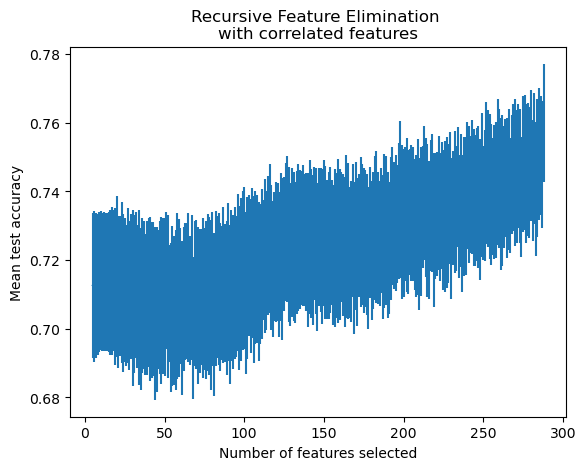

In [17]:
import matplotlib.pyplot as plt
n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    range(min_features_to_select, n_scores + min_features_to_select),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

In [18]:
#Model4 （len(columns) descriptors）
Model4_clf=DecisionTreeClassifier(max_depth = study.best_params['max_depth']
              ,max_features = study.best_params['max_features']
              #,n_estimators = study.best_params['n_estimators']
              #,learning_rate = study.best_params['learning_rate']
              ,min_samples_split= study.best_params['min_samples_split']
              ,random_state=1)
Model4_clf.fit(X_DT, y)
#Model4
Model4=Model_results(Model4_clf,X_DT,y,Cv_model)
Model4


,Mean,Se
Accuracy_test,0.760061,0.001730
Accuracy_train,0.777375,0.000822
F1 Score,0.801369,0.001472
Precision,0.737736,0.001915
Recall,0.878322,0.003298
Roc_auc,0.849823,0.001491


In [19]:
Model4_clf=Model4_clf.fit(X_DT, y)
#Saving the final model
joblib.dump(Model4_clf, './DT.pkl')
DT= joblib.load(filename='./DT.pkl')

In [20]:
#Saving the data of model performance
Model_data=pd.concat([Model1,Model2,Model3,Model4],axis=1)
Model_data.to_csv("./DT_model_data.csv",sep=',')
Model_data.columns = [['DecisionTree']*8,['Model 1','Model 1', 'Model 2','Model 2', 'Model 3', 'Model 3', 'Model 4', 'Model 4'], ['Mean', 'Se', 'Mean', 'Se', 'Mean', 'Se', 'Mean', 'Se']]  
Model_data.columns.names=['Method','Model','Values']
Model_data.to_csv('./DT_model_data.csv',encoding='utf-8')
#Read data：pd.read_csv('./Results/DT_model_data.csv',encoding='utf-8',header=[0,1,2])
Model_data

Method         DecisionTree                                                    \
Model               Model 1             Model 2             Model 3             
Values                 Mean        Se      Mean        Se      Mean        Se   
Accuracy_test      0.774946  0.001587  0.768387  0.001532  0.760061  0.001730   
Accuracy_train     0.998237  0.000025  0.998237  0.000025  0.777375  0.000822   
F1 Score           0.796314  0.001520  0.790194  0.001438  0.801369  0.001472   
Precision          0.794820  0.001623  0.789548  0.001689  0.737736  0.001915   
Recall             0.798263  0.002360  0.791309  0.002231  0.878322  0.003298   
Roc_auc            0.772876  0.001582  0.766447  0.001549  0.849823  0.001491   

Method                              
Model            Model 4            
Values              Mean        Se  
Accuracy_test   0.760061  0.001730  
Accuracy_train  0.777375  0.000822  
F1 Score        0.801369  0.001472  
Precision       0.737736  0.001915  
Recall          0.878322  0.003298  
Roc_auc         0.849823  0.001491

# LR

In [21]:
#Data pre-processing of models
X_test_NAomit=np.array(X_NAomit_data)
X_test_ML=np.array(ML_data)
y=Raw_data['Activity'].values
clf=LogisticRegression(solver='liblinear',random_state=0)

In [22]:
#Model1 （4175 descriptors）
Model1_clf=clf
#Model1
Model1=Model_results(Model1_clf,X_test_NAomit,y,Cv_model)
Model1

,Mean,Se
Accuracy_test,0.738316,0.001860
Accuracy_train,0.740835,0.001541
F1 Score,0.790610,0.001684
Precision,0.711509,0.004040
Recall,0.900209,0.008311
Roc_auc,0.839094,0.001722


In [23]:
#Model2 （40 descriptors）
Model2_clf=clf
Model2_clf.fit(X_test_ML, y)
#Model2
Model2=Model_results(Model2_clf,X_test_ML,y,Cv_model)
Model2

,Mean,Se
Accuracy_test,0.787221,0.001473
Accuracy_train,0.808556,0.000215
F1 Score,0.810725,0.001352
Precision,0.795705,0.001525
Recall,0.826665,0.002020
Roc_auc,0.889802,0.001135


In [24]:
#Tuning hyperparameters
#Step 1. Define an objective function to be maximized.
def objective(trial):
    logreg_c = trial.suggest_float("logreg_c", 1e-3,  1e3, log=True)
    l1_ratio = trial.suggest_float("l1_ratio",0.1,1,log=False) 
    #penalty = trial.suggest_categorical("penalty",['l1','l2'])
    max_iter = trial.suggest_int("max_iter", 100,2000)
    model =LogisticRegression(C=logreg_c,
                              max_iter=max_iter,
                              l1_ratio=l1_ratio,
                              solver='liblinear',random_state=1)
    
# Step 2: Scoring method:
    score = model_selection.cross_val_score(model, X_test_ML, y, n_jobs=8, scoring="accuracy",cv=Cv_optuna)
    accuracy = score.mean()
    return accuracy

# Step 3: Running it
study = optuna.create_study(direction="maximize",sampler=optuna.samplers.TPESampler(seed=1))
study.optimize(objective, n_trials=100, show_progress_bar=False)


[I 2023-11-06 01:51:46,682] A new study created in memory with name: no-name-8b6bcd37-fe15-48d5-89b5-68e5fb2df865
[I 2023-11-06 01:51:53,517] Trial 0 finished with value: 0.7829135392571844 and parameters: {'logreg_c': 0.3177840006884068, 'l1_ratio': 0.7482920440979423, 'max_iter': 100}. Best is trial 0 with value: 0.7829135392571844.
[I 2023-11-06 01:51:57,853] Trial 1 finished with value: 0.779917179378242 and parameters: {'logreg_c': 0.0651621545821569, 'l1_ratio': 0.23208030173540176, 'max_iter': 275}. Best is trial 0 with value: 0.7829135392571844.
[I 2023-11-06 01:52:01,514] Trial 2 finished with value: 0.766136777286484 and parameters: {'logreg_c': 0.013108749615263334, 'l1_ratio': 0.411004654338743, 'max_iter': 854}. Best is trial 0 with value: 0.7829135392571844.
[I 2023-11-06 01:52:15,282] Trial 3 finished with value: 0.7892788469103555 and parameters: {'logreg_c': 1.7096232052870346, 'l1_ratio': 0.4772750629629653, 'max_iter': 1402}. Best is trial 3 with value: 0.78927884691

In [25]:
# Getting the best parameters:
print(f"The best parameters are : \n{study.best_params}")
# Setting the best model
clf=LogisticRegression(C=study.best_params['logreg_c'],
                              max_iter=study.best_params['max_iter'],
                              l1_ratio=study.best_params['l1_ratio'],
                              solver='liblinear',
                              random_state=1)

The best parameters are : 
{'logreg_c': 429.4210216262864, 'l1_ratio': 0.2738872739311075, 'max_iter': 1566}


In [26]:
#Model3
Model3=Model_results(clf,X_test_ML,y,Cv_model)
Model3

,Mean,Se
Accuracy_test,0.795189,0.001573
Accuracy_train,0.828961,0.000240
F1 Score,0.816889,0.001464
Precision,0.805600,0.001557
Recall,0.828835,0.002143
Roc_auc,0.891130,0.001150


In [27]:
#Recursive feature elimination
min_features_to_select =5
rfecv = RFECV(estimator=clf,step=1,cv=Cv_RFECV,scoring="accuracy",min_features_to_select=min_features_to_select,n_jobs=8)
rfecv.fit(X_test_ML,y)
columns=Series(ML_data.columns.tolist())[rfecv.support_.tolist()].tolist()

In [28]:
data_lr=ML_data[columns]
data_lr.to_csv("./data_lr.csv",sep=',')
X_LR=np.array(data_lr)

In [29]:
data_lr

,CATS2D_02_AL,CATS2D_06_AL,P_VSA_MR_5,SAscore,P_VSA_LogP_5,CATS2D_07_AL,Eta_betaS_A,F04[N-N],CATS2D_08_LL,D/Dtr09,...,Cl-090,s4_numSharedNeighbors,CATS2D_04_NL,T(S..S),CATS2D_07_DD,N-068,N-067,nImidazoles,nROCON,H-048
cid,,,,,,,,,,,,,,,,,,,,,
2083077.0,0.366667,0.081967,0.021267,0.258958,0.174110,0.108434,0.811912,0.000000,0.046512,0.000000,...,0.0,0.0,0.000,0.104167,0.000000,0.0,0.0,0.0,0.0,0.0625
138703696.0,0.433333,0.131148,0.092569,0.370407,0.505067,0.048193,0.848485,0.555556,0.081395,0.028828,...,0.0,0.0,0.000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0625
139316163.0,0.366667,0.163934,0.081090,0.363123,0.494151,0.084337,0.856061,0.555556,0.069767,0.032652,...,0.0,0.0,0.000,0.000000,0.000000,0.0,0.0,0.0,0.5,0.0000
139315919.0,0.333333,0.163934,0.087125,0.361647,0.344681,0.036145,0.840326,0.555556,0.058140,0.029651,...,0.0,0.0,0.000,0.000000,0.000000,0.0,0.0,0.0,0.5,0.0000
138703798.0,0.333333,0.163934,0.088677,0.383732,0.292887,0.084337,0.839646,0.555556,0.081395,0.025624,...,0.0,0.0,0.000,0.000000,0.000000,0.0,0.2,0.0,0.0,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2158020.0,0.133333,0.016393,0.039427,0.290846,0.367082,0.048193,0.821114,0.000000,0.058140,0.022902,...,0.0,0.0,0.000,0.000000,0.047619,0.0,0.0,0.0,0.0,0.0000
9631088.0,0.066667,0.000000,0.012282,0.183675,0.106439,0.000000,0.748663,0.000000,0.046512,0.000000,...,0.0,0.0,0.125,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0625
3247362.0,0.133333,0.131148,0.054764,0.347666,0.152410,0.132530,0.781818,0.111111,0.220930,0.000000,...,0.0,0.0,0.000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0000


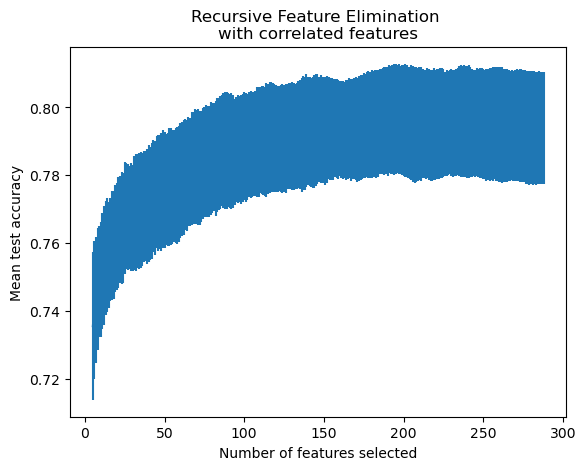

In [30]:
import matplotlib.pyplot as plt

n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    range(min_features_to_select, n_scores + min_features_to_select),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

In [31]:
#Model4 （len(columns) descriptors）
Model4_clf=LogisticRegression(C=study.best_params['logreg_c'],max_iter=study.best_params['max_iter'],solver='liblinear',random_state=0)
#Model4
Model4=Model_results(Model4_clf,X_LR,y,Cv_model)
Model4


,Mean,Se
Accuracy_test,0.802558,0.001545
Accuracy_train,0.825484,0.000229
F1 Score,0.823670,0.001403
Precision,0.811560,0.001644
Recall,0.836502,0.002033
Roc_auc,0.897727,0.001134


In [32]:
Model4_clf=Model4_clf.fit(X_LR, y)
#Saving the final model
joblib.dump(Model4_clf, './LogReg.pkl')
LogReg= joblib.load(filename='./LogReg.pkl')

In [33]:
#Saving the data of model performance
Model_data=pd.concat([Model1,Model2,Model3,Model4],axis=1)
Model_data.to_csv("./LR_model_data.csv",sep=',')
Model_data.columns = [['LogisticRegression']*8,['Model 1','Model 1', 'Model 2','Model 2', 'Model 3', 'Model 3', 'Model 4', 'Model 4'], ['Mean', 'Se', 'Mean', 'Se', 'Mean', 'Se', 'Mean', 'Se']]  
Model_data.columns.names=['Method','Model','Values']
Model_data.to_csv('./LR_model_data.csv',encoding='utf-8')
#Read data：pd.read_csv('./Results/LR_model_data.csv',encoding='utf-8',header=[0,1,2])
Model_data

Method         LogisticRegression                                          \
Model                     Model 1             Model 2             Model 3   
Values                       Mean        Se      Mean        Se      Mean   
Accuracy_test            0.738316  0.001860  0.787221  0.001473  0.795189   
Accuracy_train           0.740835  0.001541  0.808556  0.000215  0.828961   
F1 Score                 0.790610  0.001684  0.810725  0.001352  0.816889   
Precision                0.711509  0.004040  0.795705  0.001525  0.805600   
Recall                   0.900209  0.008311  0.826665  0.002020  0.828835   
Roc_auc                  0.839094  0.001722  0.889802  0.001135  0.891130   

Method                                        
Model                      Model 4            
Values                Se      Mean        Se  
Accuracy_test   0.001573  0.802558  0.001545  
Accuracy_train  0.000240  0.825484  0.000229  
F1 Score        0.001464  0.823670  0.001403  
Precision       0.001557  0.811560  0.001644  
Recall          0.002143  0.836502  0.002033  
Roc_auc         0.001150  0.897727  0.001134

# RF

In [9]:
#Data pre-processing of models
X_test_NAomit=np.array(X_NAomit_data)
X_test_ML=np.array(ML_data)
y=Raw_data['Activity'].values
clf=RandomForestClassifier(random_state=0)

In [10]:
#Model1 （4175 descriptors）
Model1_clf=clf
#Model1
Model1=Model_results(Model1_clf,X_test_NAomit,y,Cv_model)
Model1

,Mean,Se
Accuracy_test,0.823302,0.001415
Accuracy_train,0.998233,0.000025
F1 Score,0.846165,0.001209
Precision,0.814041,0.001600
Recall,0.881260,0.001727
Roc_auc,0.916406,0.000911


In [11]:
#Model2 （40 descriptors）
Model2_clf=clf
Model2_clf.fit(X_test_ML, y)
#Model2
Model2=Model_results(Model2_clf,X_test_ML,y,Cv_model)
Model2

,Mean,Se
Accuracy_test,0.826736,0.001332
Accuracy_train,0.998233,0.000025
F1 Score,0.848439,0.001168
Precision,0.819689,0.001461
Recall,0.879588,0.001759
Roc_auc,0.920638,0.000875


In [12]:
#Tuning hyperparameters
#Step 1. Define an objective function to be maximized.
def objective(trial):
    n_estimators = trial.suggest_int("n_estimators",100,1000,1) #整数型，(参数名称，下界，上界，步长)
    max_depth = trial.suggest_int("max_depth",5,20,1)
    max_features = trial.suggest_int("max_features",5,30,1)
    #max_features = trial.suggest_categorical("max_features",["log2","sqrt","auto"]) #字符型
    min_impurity_decrease = trial.suggest_float("min_impurity_decrease",0,5,log=False) #浮点型
    model = RandomForestClassifier(n_estimators = n_estimators
              ,max_depth = max_depth
              ,max_features = max_features
              ,min_impurity_decrease = min_impurity_decrease
              ,random_state=0
              ,verbose=False
              ,n_jobs=8)

# Step 2: Scoring method:
    score = model_selection.cross_val_score(model, X_test_ML, y, n_jobs=8, scoring="accuracy",cv=Cv_optuna)
    accuracy = score.mean()
    return accuracy
 
# Step 3: Running it
study = optuna.create_study(direction="maximize",sampler=optuna.samplers.TPESampler(seed=0))
study.optimize(objective, n_trials=100, show_progress_bar=False)

[I 2023-11-14 02:31:20,654] A new study created in memory with name: no-name-698540f7-3793-4b60-875c-c7a6f849dcb0
[I 2023-11-14 02:31:40,749] Trial 0 finished with value: 0.5514167099389993 and parameters: {'n_estimators': 594, 'max_depth': 16, 'max_features': 20, 'min_impurity_decrease': 2.724415914984484}. Best is trial 0 with value: 0.5514167099389993.
[I 2023-11-14 02:31:54,588] Trial 1 finished with value: 0.5514167099389993 and parameters: {'n_estimators': 481, 'max_depth': 15, 'max_features': 16, 'min_impurity_decrease': 4.4588650039103985}. Best is trial 0 with value: 0.5514167099389993.
[I 2023-11-14 02:32:25,532] Trial 2 finished with value: 0.5514167099389993 and parameters: {'n_estimators': 968, 'max_depth': 11, 'max_features': 25, 'min_impurity_decrease': 2.644474598764522}. Best is trial 0 with value: 0.5514167099389993.
[I 2023-11-14 02:32:40,250] Trial 3 finished with value: 0.5514167099389993 and parameters: {'n_estimators': 611, 'max_depth': 19, 'max_features': 6, 'mi

In [13]:
# Getting the best parameters:
print(f"The best parameters are : \n{study.best_params}")
# Setting the best model
clf=RandomForestClassifier(n_estimators = study.best_params['n_estimators']
              ,max_depth = study.best_params['max_depth']
              ,max_features = study.best_params['max_features']
              ,min_impurity_decrease = study.best_params['min_impurity_decrease']
              ,random_state=0
              ,verbose=False
              ,n_jobs=8)

The best parameters are : 
{'n_estimators': 768, 'max_depth': 7, 'max_features': 28, 'min_impurity_decrease': 0.0007392099609671288}


In [14]:
#Model3
Model3=Model_results(clf,X_test_ML,y,Cv_model)
Model3

,Mean,Se
Accuracy_test,0.796548,0.001444
Accuracy_train,0.846091,0.000258
F1 Score,0.832272,0.001138
Precision,0.763334,0.001496
Recall,0.915270,0.001728
Roc_auc,0.899963,0.001122


In [15]:
#Recursive feature elimination
min_features_to_select =5
rfecv = RFECV(estimator=clf,step=1,cv=Cv_RFECV,scoring="accuracy",min_features_to_select=min_features_to_select,n_jobs=8)
rfecv.fit(X_test_ML,y)
columns=Series(ML_data.columns.tolist())[rfecv.support_.tolist()].tolist()

In [16]:
data_rf=ML_data[columns]
data_rf.to_csv("./data_rf.csv",sep=',')
X_RF=np.array(data_rf)

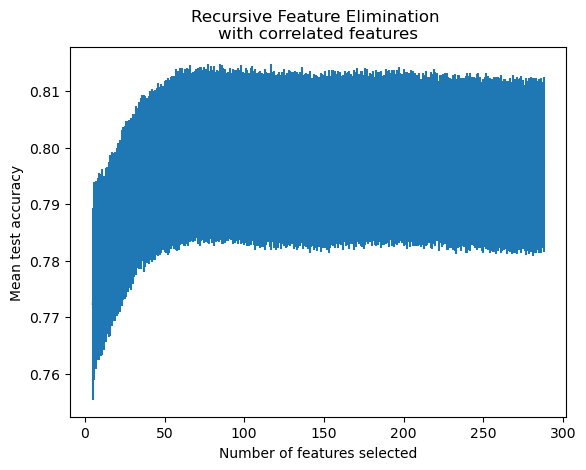

In [17]:
import matplotlib.pyplot as plt
n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    range(min_features_to_select, n_scores + min_features_to_select),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

In [18]:
#Model4 （len(columns) descriptors）
Model4_clf=clf=RandomForestClassifier(n_estimators = study.best_params['n_estimators']
              ,max_depth = study.best_params['max_depth']
              ,max_features = study.best_params['max_features']
              ,min_impurity_decrease = study.best_params['min_impurity_decrease']
              ,random_state=0
              ,verbose=False
              ,n_jobs=8)
Model4_clf.fit(X_RF, y)
#Model4
Model4=Model_results(Model4_clf,X_RF,y,Cv_model)
Model4


,Mean,Se
Accuracy_test,0.799285,0.001400
Accuracy_train,0.851433,0.000261
F1 Score,0.833321,0.001117
Precision,0.768939,0.001461
Recall,0.909807,0.001672
Roc_auc,0.899491,0.001085


In [19]:
Model4_clf=Model4_clf.fit(X_RF, y)
#Saving the final model
joblib.dump(Model4_clf, './RF.pkl')
RF= joblib.load(filename='./RF.pkl')

In [20]:
#Saving the data of model performance
Model_data=pd.concat([Model1,Model2,Model3,Model4],axis=1)
Model_data.to_csv("./RF_model_data.csv",sep=',')
Model_data.columns = [['RandomForest']*8,['Model 1','Model 1', 'Model 2','Model 2', 'Model 3', 'Model 3', 'Model 4', 'Model 4'], ['Mean', 'Se', 'Mean', 'Se', 'Mean', 'Se', 'Mean', 'Se']]  
Model_data.columns.names=['Method','Model','Values']
Model_data.to_csv('./RF_model_data.csv',encoding='utf-8')
#Read data：pd.read_csv('./Results/RF_model_data.csv',encoding='utf-8',header=[0,1,2])
Model_data

Method         RandomForest                                                    \
Model               Model 1             Model 2             Model 3             
Values                 Mean        Se      Mean        Se      Mean        Se   
Accuracy_test      0.823302  0.001415  0.826736  0.001332  0.796548  0.001444   
Accuracy_train     0.998233  0.000025  0.998233  0.000025  0.846091  0.000258   
F1 Score           0.846165  0.001209  0.848439  0.001168  0.832272  0.001138   
Precision          0.814041  0.001600  0.819689  0.001461  0.763334  0.001496   
Recall             0.881260  0.001727  0.879588  0.001759  0.915270  0.001728   
Roc_auc            0.916406  0.000911  0.920638  0.000875  0.899963  0.001122   

Method                              
Model            Model 4            
Values              Mean        Se  
Accuracy_test   0.799285  0.001400  
Accuracy_train  0.851433  0.000261  
F1 Score        0.833321  0.001117  
Precision       0.768939  0.001461  
Recall          0.909807  0.001672  
Roc_auc         0.899491  0.001085

# xgboost

In [9]:
#Data pre-processing of models
X_test_NAomit=np.array(X_NAomit_data)
X_test_ML=np.array(ML_data)
y=Raw_data['Activity'].values
clf=xgb.XGBClassifier(random_state=0)

In [10]:
#Model1 （4175 descriptors）
Model1_clf=clf
#Model1
Model1=Model_results(Model1_clf,X_test_NAomit,y,Cv_model)
Model1

,Mean,Se
Accuracy_test,0.826184,0.001273
Accuracy_train,0.998237,0.000025
F1 Score,0.846148,0.001150
Precision,0.826559,0.001414
Recall,0.867016,0.001837
Roc_auc,0.919177,0.000897


In [11]:
#Model2 （40 descriptors）
Model2_clf=clf
Model2_clf.fit(X_test_ML, y)
#Model2
Model2=Model_results(Model2_clf,X_test_ML,y,Cv_model)
Model2

,Mean,Se
Accuracy_test,0.817001,0.001387
Accuracy_train,0.998237,0.000025
F1 Score,0.837713,0.001216
Precision,0.819971,0.001607
Recall,0.856560,0.001712
Roc_auc,0.913591,0.000922


In [12]:
#Tuning hyperparameters
#Step 1. Define an objective function to be maximized.
def objective(trial):
    param = {
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3,1.0,step=0.1),
        'subsample': trial.suggest_float('subsample', 0.4, 1.0, step=0.1),
        'learning_rate': trial.suggest_float('learning_rate', 0.0001, 0.2, step=0.005),
        'n_estimators': trial.suggest_int("n_estimators",50,1000,1)
        #'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
    }
    model = xgb.XGBClassifier(**param,random_state=1,n_jobs=8)

 
# Step 2: Scoring method:
    score = model_selection.cross_val_score(model, X_test_ML, y, n_jobs=8, scoring="accuracy",cv=Cv_optuna)
    accuracy = score.mean()
    return accuracy

# Step 3: Running it
study = optuna.create_study(direction="maximize",sampler=optuna.samplers.TPESampler(seed=0))
study.optimize(objective, n_trials=100, show_progress_bar=False)


[I 2023-11-12 17:06:00,398] A new study created in memory with name: no-name-ff205370-d3ea-44bf-9a29-e4334d80174a
[I 2023-11-12 17:10:47,824] Trial 0 finished with value: 0.8261199404153097 and parameters: {'lambda': 0.15676677195506075, 'alpha': 0.7257005721594281, 'colsample_bytree': 0.7, 'subsample': 0.7000000000000001, 'learning_rate': 0.0801, 'n_estimators': 664}. Best is trial 0 with value: 0.8261199404153097.
[I 2023-11-12 17:15:15,191] Trial 1 finished with value: 0.8225564244989587 and parameters: {'lambda': 0.0562793204741517, 'alpha': 3.6905577292137624, 'colsample_bytree': 1.0, 'subsample': 0.6000000000000001, 'learning_rate': 0.1551, 'n_estimators': 552}. Best is trial 0 with value: 0.8261199404153097.
[I 2023-11-12 17:17:39,739] Trial 2 finished with value: 0.787917001043781 and parameters: {'lambda': 0.18714500686240676, 'alpha': 5.039489598671215, 'colsample_bytree': 0.3, 'subsample': 0.4, 'learning_rate': 0.0001, 'n_estimators': 841}. Best is trial 0 with value: 0.8261

In [13]:
# Getting the best parameters:
print(f"The best parameters are : \n{study.best_params}")
# Setting the best model
clf=xgb.XGBClassifier(alpha = study.best_params['alpha']
              ,colsample_bytree = study.best_params['colsample_bytree']
              ,subsample = study.best_params['subsample']
              ,n_estimators = study.best_params['n_estimators']
              ,learning_rate= study.best_params['learning_rate'], n_jobs=8
              ,random_state=0)

The best parameters are : 
{'lambda': 0.09196398504120694, 'alpha': 0.9827416953928295, 'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.035100000000000006, 'n_estimators': 628}


In [14]:
#Model3
Model3=Model_results(clf,X_test_ML,y,Cv_model)
Model3

,Mean,Se
Accuracy_test,0.826589,0.001488
Accuracy_train,0.998129,0.000027
F1 Score,0.847212,0.001288
Precision,0.824221,0.001699
Recall,0.871862,0.001767
Roc_auc,0.921516,0.000908


In [15]:
#Recursive feature elimination
min_features_to_select =5
rfecv = RFECV(estimator=clf,step=1,cv=Cv_RFECV,scoring="accuracy",min_features_to_select=min_features_to_select,n_jobs=8)
rfecv.fit(X_test_ML,y)
columns=Series(ML_data.columns.tolist())[rfecv.support_.tolist()].tolist()

In [16]:
data_xgb=ML_data[columns]
data_xgb.to_csv("./data_xgb.csv",sep=',')
X_XGB=np.array(data_xgb)

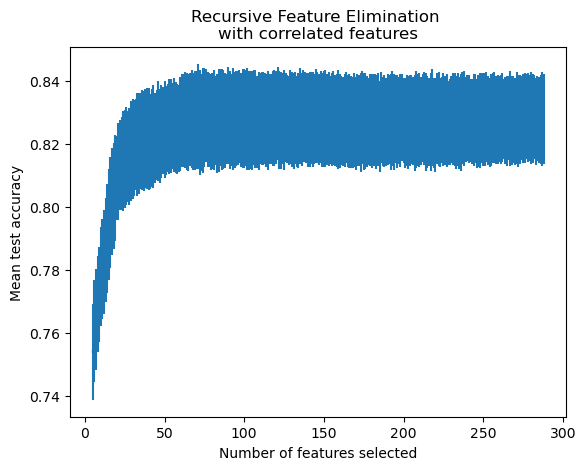

In [17]:
import matplotlib.pyplot as plt
n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    range(min_features_to_select, n_scores + min_features_to_select),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

In [18]:
#Model4 （len(columns) descriptors）
Model4_clf=xgb.XGBClassifier(alpha = study.best_params['alpha']
              ,colsample_bytree = study.best_params['colsample_bytree']
              ,subsample = study.best_params['subsample']
              ,n_estimators = study.best_params['n_estimators']
              ,learning_rate= study.best_params['learning_rate'], n_jobs=8
              ,random_state=0)
Model4_clf.fit(X_XGB, y)
#Model4
Model4=Model_results(Model4_clf,X_XGB,y,Cv_model)
Model4


,Mean,Se
Accuracy_test,0.832566,0.001380
Accuracy_train,0.997834,0.000031
F1 Score,0.852326,0.001245
Precision,0.829771,0.001498
Recall,0.876502,0.001954
Roc_auc,0.925782,0.000836


In [19]:
Model4_clf=Model4_clf.fit(X_XGB, y)
#Saving the final model
joblib.dump(Model4_clf, './XGB.pkl')
XGB= joblib.load(filename='./XGB.pkl')

In [20]:
#Saving the data of model performance
Model_data=pd.concat([Model1,Model2,Model3,Model4],axis=1)
Model_data.to_csv("./XGB_model_data.csv",sep=',')
Model_data.columns = [['XGBoost']*8,['Model 1','Model 1', 'Model 2','Model 2', 'Model 3', 'Model 3', 'Model 4', 'Model 4'], ['Mean', 'Se', 'Mean', 'Se', 'Mean', 'Se', 'Mean', 'Se']]  
Model_data.columns.names=['Method','Model','Values']
Model_data.to_csv('./XGB_model_data.csv',encoding='utf-8')
#Read data：pd.read_csv('./Results/LR_model_data.csv',encoding='utf-8',header=[0,1,2])
Model_data

Method           XGBoost                                                    \
Model            Model 1             Model 2             Model 3             
Values              Mean        Se      Mean        Se      Mean        Se   
Accuracy_test   0.826184  0.001273  0.817001  0.001387  0.826589  0.001488   
Accuracy_train  0.998237  0.000025  0.998237  0.000025  0.998129  0.000027   
F1 Score        0.846148  0.001150  0.837713  0.001216  0.847212  0.001288   
Precision       0.826559  0.001414  0.819971  0.001607  0.824221  0.001699   
Recall          0.867016  0.001837  0.856560  0.001712  0.871862  0.001767   
Roc_auc         0.919177  0.000897  0.913591  0.000922  0.921516  0.000908   

Method                              
Model            Model 4            
Values              Mean        Se  
Accuracy_test   0.832566  0.001380  
Accuracy_train  0.997834  0.000031  
F1 Score        0.852326  0.001245  
Precision       0.829771  0.001498  
Recall          0.876502  0.001954  
Roc_auc         0.925782  0.000836

In [89]:
from sklearn.preprocessing import StandardScaler

In [1]:
#Importing packages
#Model
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
#Sklearn
from sklearn import model_selection, linear_model
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV,RepeatedStratifiedKFold,cross_validate
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,auc,roc_auc_score,roc_curve,classification_report

In [31]:
#Import packages

#Rdkit
from rdkit import Chem

#Pandas
import pandas as pd
from pandas import DataFrame

#Others
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

import joblib
import random
import numpy as np
import os
import math
import warnings

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from plotnine import *

In [32]:
#Others
import random
import pandas as pd
from pandas import DataFrame
from pandas import Series
import numpy as np
import math
import os
import warnings
import optuna
import joblib

In [38]:
def print_RxC(dataframe):
    rows= dataframe.shape[0]
    columns= dataframe.shape[1]
    rows_columns=print(dataframe.shape[0],"Moleculars ×",dataframe.shape[1],"Descriptors")
    return rows_columns
def trimm_correlated(df_in, threshold):
    df_corr = df_in.corr(method='spearman')
    df_not_correlated = ~(df_corr.mask(np.tril(np.ones([len(df_corr)]*2, dtype=bool))).abs() > threshold).any()
    un_corr_idx = df_not_correlated.loc[df_not_correlated[df_not_correlated.index] == True].index
    df_out = df_in[un_corr_idx]
    return df_out

In [39]:
#Set the Work Path
warnings.filterwarnings ('ignore')
#Work Path
os.chdir("C:\\Users\\A\\Desktop\\Bioactive\\TNF-α")
from alvadesccliwrapper.alvadesc import AlvaDesc
#AlvaDesc Path(Linux default alvaDescCLI location)
aDesc = AlvaDesc('E:\\C++\\alvaDesc\\alvaDescCLI.exe') 

In [46]:
aDesc

alvaDescCLI.
Version 2.0 for Win64 (x86_64) - v.2.0.12 - built on: 2022/05/11

In [92]:
XGB= joblib.load(filename='./XGB.pkl')
Transformer= joblib.load(filename='./Scaler_transformer.pkl')

In [48]:
Pubchem_data=pd.read_csv("./Pubchem_data_clearn.csv",sep=',',index_col=0)
Pubchem_data

,Iso_smiles,Type,Canonical_smiles
cid,,,
5273,C1CC(OC1)[N+]2=CNC3=C(N=CN=C32)N,Adenosine,Nc1ncnc2c1[nH]c[n+]2C1CCCO1
13463,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)CCl)O)O)N,Adenosine,Nc1ncnc2c1ncn2C1OC(CCl)C(O)C1O
39148,CN(C)C1[C@H](O[C@H](C1O)N2C=NC3=C(N=CN=C32)N)CO,Adenosine,CN(C)C1C(O)[C@H](n2cnc3c(N)ncnc32)O[C@@H]1CO
56328,C1[C@H](O[C@H](C1F)N2C=NC3=C(N=CN=C32)N)CO,Adenosine,Nc1ncnc2c1ncn2[C@@H]1O[C@H](CO)CC1F
67358,C1=NC(=C2C(=N1)N(C=[N+]2[O-])[C@H]3[C@@H]([C@@...,Adenosine,Nc1ncnc2c1[n+]([O-])cn2[C@@H]1O[C@H](CO)[C@@H]...
...,...,...,...
121487078,C1[C@@H](O[C@@H](C1CCC#N)CO)N2C=CC(=O)NC2=O,Uridine,N#CCCC1C[C@H](n2ccc(=O)[nH]c2=O)O[C@@H]1CO
121487098,C1=CN(C(=O)NC1=O)[C@H]2C(C([C@H](O2)CO)F)[N+]3...,Uridine,O=c1ccn([C@@H]2O[C@H](CO)C(F)C2[n+]2cc[nH]c2)c...
121487432,CC1=CN(C(=O)NC1=O)[C@H]2[C@@H]([C@H]([C@H](O2)...,Uridine,Cc1cn([C@@H]2O[C@H](CO)[C@H](C(F)(F)F)[C@H]2O)...


In [49]:
X_scaled_data=pd.read_csv("./X_scaled_data.csv",sep=',',index_col=0)


,MW,SpAbs_Dz(p),HyWi_Dz(p),H_Dz(p),AVS_Dz(p),Wi_Dz(p),SM6_Dz(m),SM5_Dz(m),SM4_Dz(m),SM3_Dz(m),...,nImidazoles,CATS2D_01_DA,nROCON,F10[C-Cl],B10[C-Cl],NaaS,H-048,SaaS,F06[N-S],Cl-089
cid,,,,,,,,,,,,,,,,,,,,,
2083077.0,0.100131,0.013547,0.507587,0.063662,0.013296,0.001367,0.527579,0.525839,0.525696,0.519653,...,0.0,0.0,0.0,0.0,0.0,0.5,0.0625,0.419647,0.0,0.000000
138703696.0,0.125832,0.022601,0.560922,0.087584,0.022005,0.003041,0.589174,0.588881,0.586344,0.586353,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0625,0.000000,0.0,0.000000
139316163.0,0.140863,0.032947,0.604614,0.081076,0.031646,0.004710,0.619311,0.618891,0.616900,0.616028,...,0.0,0.0,0.5,0.0,0.0,0.0,0.0000,0.000000,0.0,0.000000
139315919.0,0.129659,0.025849,0.575313,0.077144,0.024839,0.003432,0.599286,0.599006,0.596526,0.596546,...,0.0,0.0,0.5,0.0,0.0,0.0,0.0000,0.000000,0.0,0.000000
138703798.0,0.116939,0.019948,0.547034,0.076446,0.019465,0.002483,0.577807,0.577463,0.574934,0.574815,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2158020.0,0.109415,0.015771,0.521982,0.064281,0.015589,0.001713,0.546721,0.545390,0.544634,0.540213,...,0.0,0.0,0.0,0.3,1.0,0.0,0.0000,0.000000,0.0,0.166667
9631088.0,0.054518,0.006022,0.420121,0.030603,0.006026,0.000363,0.429805,0.427252,0.427849,0.418949,...,0.0,0.5,0.0,0.0,0.0,0.5,0.0625,0.432963,0.0,0.000000
3247362.0,0.109812,0.018124,0.540971,0.082993,0.018233,0.002262,0.578905,0.577664,0.576976,0.572792,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.000000


In [82]:
X_scaled_data1=X_scaled_data.iloc[:,0:500]
X_scaled_data1

,MW,SpAbs_Dz(p),HyWi_Dz(p),H_Dz(p),AVS_Dz(p),Wi_Dz(p),SM6_Dz(m),SM5_Dz(m),SM4_Dz(m),SM3_Dz(m),...,SpMax3_Bh(m),ATSC2p,D/Dtr05,ATSC5p,ATSC3p,P_VSA_LogP_4,S2K,nAB,CIC0,nAA
cid,,,,,,,,,,,,,,,,,,,,,
2083077.0,0.100131,0.013547,0.507587,0.063662,0.013296,0.001367,0.527579,0.525839,0.525696,0.519653,...,0.372243,0.022892,0.078366,0.101536,0.081039,0.040529,0.065557,0.403846,0.513154,0.42
138703696.0,0.125832,0.022601,0.560922,0.087584,0.022005,0.003041,0.589174,0.588881,0.586344,0.586353,...,0.362820,0.022152,0.062902,0.092881,0.101592,0.089530,0.081191,0.519231,0.562516,0.52
139316163.0,0.140863,0.032947,0.604614,0.081076,0.031646,0.004710,0.619311,0.618891,0.616900,0.616028,...,0.362431,0.028201,0.032011,0.105194,0.128660,0.086579,0.088034,0.307692,0.582759,0.30
139315919.0,0.129659,0.025849,0.575313,0.077144,0.024839,0.003432,0.599286,0.599006,0.596526,0.596546,...,0.357755,0.025724,0.029036,0.104855,0.117075,0.086579,0.085822,0.307692,0.574868,0.30
138703798.0,0.116939,0.019948,0.547034,0.076446,0.019465,0.002483,0.577807,0.577463,0.574934,0.574815,...,0.359814,0.027299,0.073900,0.102270,0.132966,0.071729,0.074082,0.307692,0.588900,0.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2158020.0,0.109415,0.015771,0.521982,0.064281,0.015589,0.001713,0.546721,0.545390,0.544634,0.540213,...,0.364957,0.023778,0.022369,0.138346,0.112048,0.000000,0.081511,0.307692,0.561648,0.30
9631088.0,0.054518,0.006022,0.420121,0.030603,0.006026,0.000363,0.429805,0.427252,0.427849,0.418949,...,0.313858,0.010716,0.014679,0.029427,0.046071,0.063456,0.042351,0.211538,0.396835,0.22
3247362.0,0.109812,0.018124,0.540971,0.082993,0.018233,0.002262,0.578905,0.577664,0.576976,0.572792,...,0.361476,0.027584,0.000000,0.141217,0.134728,0.059075,0.072242,0.442308,0.615176,0.44


In [83]:
X_scaled_data2=X_scaled_data.iloc[:,500:1261]
X_scaled_data2

,SAacc,P_VSA_v_2,SpMax_A,SpPosA_L,DELS,DECC,nCsp2,Eta_epsi_3,P_VSA_p_2,ATSC1p,...,nImidazoles,CATS2D_01_DA,nROCON,F10[C-Cl],B10[C-Cl],NaaS,H-048,SaaS,F06[N-S],Cl-089
cid,,,,,,,,,,,,,,,,,,,,,
2083077.0,0.032242,0.032352,0.774812,0.911544,0.002911,0.180345,0.193182,0.791325,0.032352,0.051319,...,0.0,0.0,0.0,0.0,0.0,0.5,0.0625,0.419647,0.0,0.000000
138703696.0,0.093664,0.092243,0.777721,0.910814,0.006516,0.171564,0.238636,0.789735,0.086259,0.055508,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0625,0.000000,0.0,0.000000
139316163.0,0.103084,0.101473,0.778737,0.904762,0.009726,0.196583,0.159091,0.776638,0.083520,0.070766,...,0.0,0.0,0.5,0.0,0.0,0.0,0.0000,0.000000,0.0,0.000000
139315919.0,0.103054,0.101443,0.781473,0.889632,0.008560,0.173734,0.159091,0.744485,0.089475,0.064738,...,0.0,0.0,0.5,0.0,0.0,0.0,0.0000,0.000000,0.0,0.000000
138703798.0,0.082190,0.081000,0.779388,0.917874,0.005981,0.163680,0.147727,0.805189,0.075016,0.064360,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2158020.0,0.022100,0.028369,0.771511,0.879383,0.002884,0.143001,0.170455,0.723170,0.028369,0.060615,...,0.0,0.0,0.0,0.3,1.0,0.0,0.0000,0.000000,0.0,0.166667
9631088.0,0.041795,0.040954,0.713294,0.874680,0.001938,0.113017,0.136364,0.713514,0.040954,0.026914,...,0.0,0.5,0.0,0.0,0.0,0.5,0.0625,0.432963,0.0,0.000000
3247362.0,0.042088,0.041241,0.819209,0.920497,0.003695,0.166643,0.261364,0.810978,0.041241,0.066114,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.000000


In [84]:
X_scaled_data3=pd.concat([X_scaled_data1,X_scaled_data2],axis=1)
X_scaled_data3

,MW,SpAbs_Dz(p),HyWi_Dz(p),H_Dz(p),AVS_Dz(p),Wi_Dz(p),SM6_Dz(m),SM5_Dz(m),SM4_Dz(m),SM3_Dz(m),...,nImidazoles,CATS2D_01_DA,nROCON,F10[C-Cl],B10[C-Cl],NaaS,H-048,SaaS,F06[N-S],Cl-089
cid,,,,,,,,,,,,,,,,,,,,,
2083077.0,0.100131,0.013547,0.507587,0.063662,0.013296,0.001367,0.527579,0.525839,0.525696,0.519653,...,0.0,0.0,0.0,0.0,0.0,0.5,0.0625,0.419647,0.0,0.000000
138703696.0,0.125832,0.022601,0.560922,0.087584,0.022005,0.003041,0.589174,0.588881,0.586344,0.586353,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0625,0.000000,0.0,0.000000
139316163.0,0.140863,0.032947,0.604614,0.081076,0.031646,0.004710,0.619311,0.618891,0.616900,0.616028,...,0.0,0.0,0.5,0.0,0.0,0.0,0.0000,0.000000,0.0,0.000000
139315919.0,0.129659,0.025849,0.575313,0.077144,0.024839,0.003432,0.599286,0.599006,0.596526,0.596546,...,0.0,0.0,0.5,0.0,0.0,0.0,0.0000,0.000000,0.0,0.000000
138703798.0,0.116939,0.019948,0.547034,0.076446,0.019465,0.002483,0.577807,0.577463,0.574934,0.574815,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2158020.0,0.109415,0.015771,0.521982,0.064281,0.015589,0.001713,0.546721,0.545390,0.544634,0.540213,...,0.0,0.0,0.0,0.3,1.0,0.0,0.0000,0.000000,0.0,0.166667
9631088.0,0.054518,0.006022,0.420121,0.030603,0.006026,0.000363,0.429805,0.427252,0.427849,0.418949,...,0.0,0.5,0.0,0.0,0.0,0.5,0.0625,0.432963,0.0,0.000000
3247362.0,0.109812,0.018124,0.540971,0.082993,0.018233,0.002262,0.578905,0.577664,0.576976,0.572792,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.000000


In [85]:
aDesc.set_input_SMILES(Pubchem_data['Iso_smiles'].tolist())
if not aDesc.calculate_descriptors(X_scaled_data1.columns.tolist()):
 print('Error:' + aDesc.get_error())
else:
 X_test=pd.DataFrame(aDesc.get_output())
X_test.columns=X_scaled_data1.columns
X_test.index=Pubchem_data.index
X_test1=X_test.dropna(axis=0,how='any')
print_RxC(X_test1)
X_test1.head()

7198 Moleculars × 500 Descriptors


,MW,SpAbs_Dz(p),HyWi_Dz(p),H_Dz(p),AVS_Dz(p),Wi_Dz(p),SM6_Dz(m),SM5_Dz(m),SM4_Dz(m),SM3_Dz(m),...,SpMax3_Bh(m),ATSC2p,D/Dtr05,ATSC5p,ATSC3p,P_VSA_LogP_4,S2K,nAB,CIC0,nAA
cid,,,,,,,,,,,,,,,,,,,,,
5273,206.26,118.380642,7.140023,36.564879,54.146667,404.000006,21.071030,17.523405,14.091411,10.406821,...,3.252504,3.293385,56.323801,3.163274,3.696475,78.630836,3.431349,10.0,3.079945,9.0
13463,285.72,190.494874,8.062983,48.415156,88.434501,836.924108,23.817407,19.815686,15.919192,11.789137,...,3.525073,4.038527,79.738154,4.520116,4.970600,95.232583,4.754856,10.0,2.987205,9.0
39148,294.36,230.378561,8.412423,53.766255,106.971429,1119.600009,25.147185,20.926516,16.803419,12.460093,...,3.318750,4.314535,92.562696,6.599738,5.856571,95.232583,5.382516,10.0,3.547253,9.0
56328,253.27,187.873039,8.019371,41.812397,85.250873,763.486407,23.353702,19.430187,15.609420,11.558371,...,3.270901,3.748642,73.823468,3.698449,4.380544,95.232583,4.334691,10.0,2.994949,9.0
67358,283.28,223.797303,8.330601,47.075177,101.491334,1010.413342,24.297929,20.221731,16.234628,12.042389,...,3.306907,3.879668,84.199845,4.240842,4.638876,82.493640,4.798006,10.0,3.168008,9.0


In [86]:
aDesc.set_input_SMILES(Pubchem_data['Iso_smiles'].tolist())
if not aDesc.calculate_descriptors(X_scaled_data2.columns.tolist()):
 print('Error:' + aDesc.get_error())
else:
 X_test=pd.DataFrame(aDesc.get_output())
X_test.columns=X_scaled_data2.columns
X_test.index=Pubchem_data.index
X_test2=X_test.dropna(axis=0,how='any')
print_RxC(X_test1)
X_test2.head()

7198 Moleculars × 500 Descriptors


,SAacc,P_VSA_v_2,SpMax_A,SpPosA_L,DELS,DECC,nCsp2,Eta_epsi_3,P_VSA_p_2,ATSC1p,...,nImidazoles,CATS2D_01_DA,nROCON,F10[C-Cl],B10[C-Cl],NaaS,H-048,SaaS,F06[N-S],Cl-089
cid,,,,,,,,,,,,,,,,,,,,,
5273,77.468134,96.152757,2.465708,2.266667,13.041506,0.960000,5.0,0.450000,96.152757,1.677615,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
13463,179.620350,181.519443,2.511395,2.210526,32.072482,0.975069,5.0,0.443396,181.519443,2.178961,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
39148,182.744664,184.643757,2.524712,2.190476,30.345612,1.088435,5.0,0.442373,184.643757,2.532448,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
56328,151.897120,153.796213,2.493544,2.222222,30.632384,0.962963,5.0,0.444000,138.836100,2.027764,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
67358,232.354303,238.299982,2.535231,2.200000,41.302398,0.980000,5.0,0.448148,238.299982,2.068725,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [87]:
X_test=pd.concat([X_test1,X_test2],axis=1)

In [96]:
X_test

array([[0.04432745, 0.1       , 0.01639344, ..., 0.        , 0.        ,
        0.5       ],
       [0.06454592, 0.        , 0.        , ..., 0.        , 0.04761905,
        0.5       ],
       [0.06674436, 0.        , 0.        , ..., 0.        , 0.04761905,
        0.5       ],
       ...,
       [0.07079009, 0.13333333, 0.01639344, ..., 0.        , 0.04761905,
        0.        ],
       [0.09315356, 0.06666667, 0.01639344, ..., 0.        , 0.04761905,
        0.        ],
       [0.06518713, 0.06666667, 0.01639344, ..., 0.        , 0.0952381 ,
        0.        ]])

In [93]:
X_test_scaled=Transformer.transform(X_test)
X_test_scaled =pd.DataFrame(X_test_scaled)
X_test_scaled.columns=X_test.columns
X_test_scaled.index=X_test.index
X_test_scaled.to_csv("./X_test_data.csv",sep=',',header=1,index=1)
print_RxC(X_test_scaled)
X_test_scaled.head()

7198 Moleculars × 1261 Descriptors


,MW,SpAbs_Dz(p),HyWi_Dz(p),H_Dz(p),AVS_Dz(p),Wi_Dz(p),SM6_Dz(m),SM5_Dz(m),SM4_Dz(m),SM3_Dz(m),...,nImidazoles,CATS2D_01_DA,nROCON,F10[C-Cl],B10[C-Cl],NaaS,H-048,SaaS,F06[N-S],Cl-089
cid,,,,,,,,,,,,,,,,,,,,,
5273,0.044327,0.004352,0.377627,0.021600,0.004180,0.000221,0.383511,0.381923,0.380461,0.375382,...,0.5,0.0,0.0,0.0,0.0,0.0,0.0625,0.0,0.0,0.0
13463,0.064546,0.007027,0.430884,0.027621,0.006829,0.000459,0.434015,0.432684,0.431088,0.427043,...,0.5,0.0,0.0,0.0,0.0,0.0,0.0625,0.0,0.0,0.0
39148,0.066744,0.008507,0.451048,0.030340,0.008261,0.000614,0.458469,0.457283,0.455580,0.452118,...,0.5,0.0,0.0,0.0,0.0,0.0,0.0625,0.0,0.0,0.0
56328,0.056289,0.006930,0.428368,0.024266,0.006583,0.000418,0.425488,0.424147,0.422508,0.418418,...,0.5,0.0,0.0,0.0,0.0,0.0,0.0625,0.0,0.0,0.0
67358,0.063925,0.008262,0.446326,0.026940,0.007838,0.000554,0.442852,0.441676,0.439826,0.436507,...,0.5,0.0,0.0,0.0,0.0,0.0,0.0625,0.0,0.0,0.0


In [12]:
XGB= joblib.load(filename='./XGB.pkl')
data_xgb=pd.read_csv("./data_xgb.csv",sep=',',header=0,index_col=0)

In [13]:
# Prediction of gelability
X_test_dataframe=pd.read_csv("./X_test_data.csv",sep=',',index_col=0)
data_xgb=pd.read_csv("./data_xgb.csv",sep=',',index_col=0)
X_test_last=X_test_dataframe[data_xgb.columns.to_list()]
X_test=np.array(X_test_last)
X_test_last.head()

,MW,CATS2D_02_AL,CATS2D_06_AL,P_VSA_MR_5,SAscore,P_VSA_LogP_5,CATS2D_07_AL,Eta_betaS_A,F04[N-N],CATS2D_08_LL,...,D/Dtr10,GATS3m,SpPosA_B(m),nCb-,B10[O-S],GATS2m,P_VSA_MR_8,s4_numSharedNeighbors,CATS2D_07_DD,nImidazoles
cid,,,,,,,,,,,,,,,,,,,,,
5273,0.044327,0.100000,0.016393,0.032198,0.421468,0.127694,0.012048,0.975758,0.333333,0.0,...,0.0,0.321923,0.033274,0.0,0.0,0.436051,0.0,0.0,0.000000,0.5
13463,0.064546,0.000000,0.000000,0.019049,0.337164,0.059619,0.024096,0.954545,0.333333,0.0,...,0.0,0.277421,0.046420,0.0,0.0,0.449804,0.0,0.0,0.047619,0.5
39148,0.066744,0.000000,0.000000,0.019252,0.328731,0.074330,0.000000,0.954545,0.444444,0.0,...,0.0,0.328919,0.031668,0.0,0.0,0.426060,0.0,0.0,0.047619,0.5
56328,0.056289,0.033333,0.000000,0.020424,0.328723,0.059619,0.012048,0.954545,0.333333,0.0,...,0.0,0.335567,0.035753,0.0,0.0,0.428034,0.0,0.0,0.000000,0.5
67358,0.063925,0.000000,0.000000,0.016949,0.384495,0.059619,0.000000,0.954545,0.333333,0.0,...,0.0,0.304443,0.035535,0.0,0.0,0.414114,0.0,0.0,0.047619,0.5


In [17]:
#Predicted results
Predicted_data=pd.DataFrame(XGB.predict_proba(X_test),columns=['Probability of nonactivity','Probability of activity'])
Predicted_data.index=X_test_last.index
Predicted_data.sort_values(by="Probability of activity" , inplace=True, ascending=False)
Predicted_data.to_csv("./XGB_predict_data.csv",sep=',')

# DT